In [20]:
import os
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as ex
import seaborn as sns
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm

from desdeo_tools.utilities.fast_non_dominated_sorting import non_dominated

In [21]:
def plotly_animate(reference_data, found_solutions, colormap):
    reference_data["method"] = "reference"
    found_solutions["total_random"]["method"] = "total_random"
    found_solutions["random_selection"]["method"] = "random_selection"
    found_solutions["DSS_scipy"]["method"] = "DSS_scipy"

    num_rows = found_solutions["total_random"].shape[0]
    num_frames = 5

    tall_data = pd.DataFrame()
    for i in range(num_frames):
        end_idx = (i + 1) * num_rows // num_frames
        temp_data = reference_data
        temp_data["iteration"] = end_idx
        tall_data = pd.concat([tall_data, temp_data])

    num_rows = 500
    for method, df in found_solutions.items():
        for i in range(num_frames):
            end_idx = (i + 1) * num_rows // num_frames
            end_idx = min(end_idx, df.shape[0])
            temp_data = df.iloc[:end_idx]
            temp_data["iteration"] = (i+1) * 100
            tall_data = pd.concat([tall_data, temp_data])

    fig = ex.scatter_3d(
        tall_data,
        x="f1",
        y="f2",
        z="f3",
        color="method",
        color_discrete_map=colormap,
        animation_frame="iteration",
        range_x=[0, 1],
        range_y=[0, 1],
        range_z=[0, 1],
    )

    # make marker line width 0
    for i, trace in enumerate(fig.data):
        trace.marker.line.width = 0
        # set opacity to 1
        trace.opacity = 1
        trace.marker.size = 10
        # set opacity of reference points to 0.5
        if trace.name == "reference":
            trace.opacity = 0.3
            trace.marker.size = 5
    return fig

In [3]:
class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")
    found_solutions: list[list[float]] = Field(description="Found solutions at each iteration")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")

In [4]:
root = "../results/"
problem = "dtlz5_3"
# list all files in the directory

files = os.listdir(root)
files = [f for f in files if problem in f]

# read all the files
f_results = []
for f in files:
    with open(root + f, "r") as file:
        data = file.read()
        f_results.append(OneExperimentResults.model_validate_json(data))

In [5]:
# 3 Objective forest results

methods = list(set([r.method for r in f_results]))
runIDs = list(set([r.runID for r in f_results]))

f_pd = pd.DataFrame(
    columns=[
        "method",
        "runID",
        "iteration",
        "HV",
        "IGD",
        "spacing",
        "RSE" "Bad Reference Points Found",
        "success",
        "runtime",
    ]
)
found_solutions = {}

for r in f_results:
    # print lenghts
    to_add = pd.DataFrame(
        {
            "method": [r.method] * len(r.CumBadRefs),
            "runID": [r.runID] * len(r.CumBadRefs),
            "iteration": range(len(r.CumBadRefs)),
            "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "RSE": r.RSE + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "Bad Reference Points Found": r.CumBadRefs,
            "success": np.array(r.success).astype(int),
            "runtime": [r.runtime] * len(r.CumBadRefs),
        }
    )
    f_pd = pd.concat([f_pd, to_add])
    if r.runID == 1:
        found_solutions[r.method] = pd.DataFrame(
            r.found_solutions,
            columns=[f"f{i+1}" for i in range(len(r.found_solutions[0]))],
        )

reference_data = pd.read_csv(f"../data/{f_results[0].problemName}.csv")

reference_data = (reference_data - reference_data.min()) / (reference_data.max() - reference_data.min())

Text(0.5, 1.0, 'HV indicator for dtlz5_3')

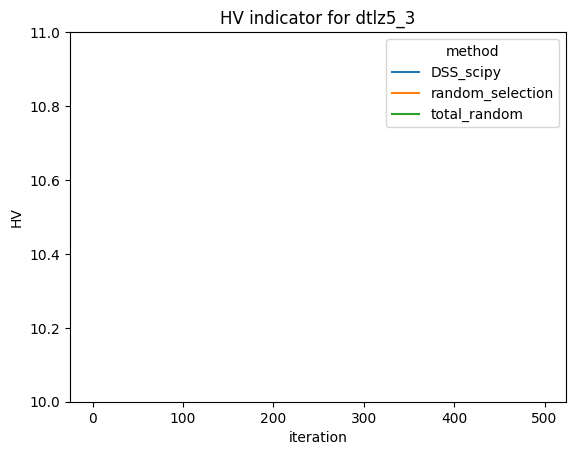

In [15]:
f, ax = plt.subplots()
ax.set()
f_pd_clean = f_pd[["HV", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd_clean.sort_values("method"), y="HV", x="iteration", hue="method")

# Set y-axis limits
ax.set_ylim(10, 11)
ax.set_title(f"HV indicator for {problem}")

# For problems where all RPs are eliminated, try recalculating the
# bad RPs with lower threshold values.

(0.0021362110911571624, 0.1)

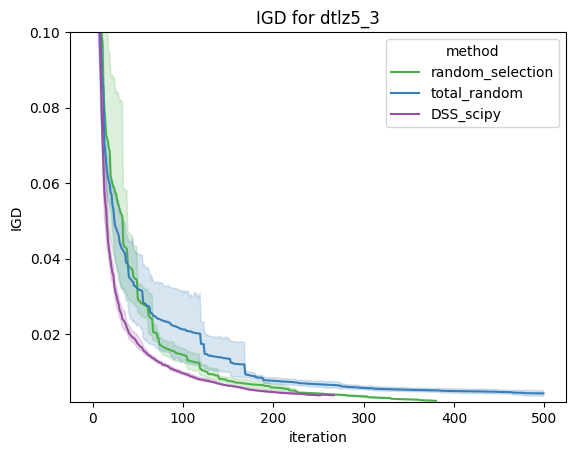

In [6]:
f, ax = plt.subplots()
# ax.set(yscale="log", xscale="log")
colormap = {
    "reference": "#e41a1c",
    "total_random": "#377eb8",
    "random_selection": "#4daf4a",
    "DSS_scipy": "#984ea3",
}

f_pd = f_pd[["IGD", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd, x="iteration", y="IGD", hue="method", palette=colormap)
ax.set_title(f"IGD for {problem}")
ax.set_ylim(0.9 * f_pd["IGD"].min(), 0.1)

# f.savefig(f"igd_{problem}.png")

In [22]:
def auto_plot(inputs):
    problem, indicator = inputs

    colormap = {
        "reference": "#e41a1c",
        "total_random": "#377eb8",
        "random_selection": "#4daf4a",
        "DSS_scipy": "#984ea3",
    }

    class OneExperimentResults(BaseModel):
        problemName: str = Field(description="Name of the problem")
        method: str = Field(description="Name of the method")
        runID: int = Field(description="Run number")
        hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
        IDG: list[float] = Field("IGD of the found solutions at each iteration")
        spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
        RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
        CumBadRefs: list[float] = Field(
            description="Cumulative fraction of bad reference points found at each iteration"
        )
        success: list[bool] = Field(
            description="Whether the method evaluated a valid reference point at each iteration"
        )
        runtime: float = Field(description="Runtime of the experiment")
        found_solutions: list[list[float]] = Field(description="Found solutions at each iteration")

    root = "../results/"
    # list all files in the directory

    files = os.listdir(root)
    files = [f for f in files if problem in f]

    # read all the files
    f_results = []
    for f in files:
        with open(root + f, "r") as file:
            data = file.read()
            f_results.append(OneExperimentResults.model_validate_json(data))

    f_pd = pd.DataFrame(
        columns=[
            "method",
            "runID",
            "iteration",
            "HV",
            "IGD",
            "spacing" "Bad Reference Points Found",
            "success",
            "runtime",
        ]
    )

    found_solutions = {}

    for r in f_results:
        to_add = pd.DataFrame(
            {
                "method": [r.method] * len(r.CumBadRefs),
                "runID": [r.runID] * len(r.CumBadRefs),
                "iteration": range(len(r.CumBadRefs)),
                "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "RSE": r.RSE + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "Bad Reference Points Found": r.CumBadRefs,
                "success": np.array(r.success).astype(int),
                "runtime": [r.runtime] * len(r.CumBadRefs),
            }
        )
        f_pd = pd.concat([f_pd, to_add])
        if r.runID == 1:
            found_solutions[r.method] = pd.DataFrame(
                r.found_solutions,
                columns=[f"f{i+1}" for i in range(len(r.found_solutions[0]))],
            )

    if problem=="forest_3":
        reference_data = pd.read_csv(f"../data/forest.csv")
        reference_data = reference_data[["Rev", "HA", "Carb"]]
        reference_data.rename(columns={"Rev": "f1", "HA": "f2", "Carb": "f3"}, inplace=True)
        reference_data = -reference_data
        reference_data = reference_data[non_dominated(reference_data.to_numpy())]
    elif problem=="forest_4":
        reference_data = pd.read_csv(f"../data/forest.csv")
        reference_data.rename(columns={"Rev": "f1", "HA": "f2", "Carb": "f3", "DW": "f4"}, inplace=True)
        reference_data = -reference_data
        reference_data = reference_data[non_dominated(reference_data.to_numpy())]
    else:
        reference_data = pd.read_csv(f"../data/{f_results[0].problemName}.csv")

    reference_data = (reference_data - reference_data.min()) / (reference_data.max() - reference_data.min())

    if indicator == "animation":
        # Only do this for 3D problems
        if reference_data.shape[1] != 3:
            return
        fig = plotly_animate(reference_data, found_solutions, colormap)
        fig.write_html(f"../figures/{problem}_animation.html")
        return

    f, ax = plt.subplots()
    ax.set()
    f_pd_clean = f_pd[[indicator, "iteration", "method"]].dropna()
    sns.lineplot(data=f_pd_clean.sort_values("method"), y=indicator, x="iteration", hue="method", palette=colormap)

    # Set y-axis limits
    if indicator == "IGD" or indicator == "spacing":
        ax.set_ylim(0.9 * f_pd[indicator].min(), 0.1)
    elif indicator == "HV":
        ax.set_ylim(f_pd_clean[indicator][f_pd_clean["iteration"] < 50].max(), 1)
    elif indicator == "RSE":
        ax.set_ylim(f_pd_clean[indicator][f_pd_clean["iteration"] < 50].min(), 0.9 * f_pd_clean[indicator].min())
    ax.set_title(f"{indicator} indicator for {problem}")
    f.savefig(f"../figures/{indicator}_{problem}.png")

In [23]:
problems = [
    "dtlz5_5",
    "dtlz5_3",
    "dtlz7",
    "dtlz5_4",
    "forest_3",
    "forest_4",
    "RE31",
    "RE32",
    "RE33",
    "RE34",
    "RE35",
    "RE36",
    "RE37",
    "RE41",
    "RE42",
    "RE61",
]

indicators = ["spacing", "HV", "IGD", "animation"]

all_figs_opts = []
for problem in problems:
    for indicator in indicators:
        all_figs_opts.append((problem, indicator))

In [24]:
results = []
with Pool(len(os.sched_getaffinity(0))) as p:
    max_exp = len(all_figs_opts)
    with tqdm(total=max_exp) as pbar:
        for i, result in enumerate(p.imap_unordered(auto_plot, all_figs_opts)):
            pbar.update()

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/bssainix/3453343/ipykernel_3407683/2681334865.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data["iteration"] = (i+1) * 100
/tmp/bssainix/3453343/ipykernel_3407683/2681334865.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data["iteration"] = (i+1) * 100
/tmp/bssainix/3453343/ipykernel_3407683/2681334865.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [24]:
methods = ["DSS_scipy", "random_selection", "total_random"]
RSE_results = pd.DataFrame(columns=["method", "problem", "RSE"])

for result in results.results:
    method = result.method
    problem = result.problemName
    RSE = result.RSE[-1]
    RSE_results = pd.concat([RSE_results, pd.DataFrame({"method": method, "problem": problem, "RSE": RSE}, index=[0])])

<Axes: xlabel='problem', ylabel='RSE'>

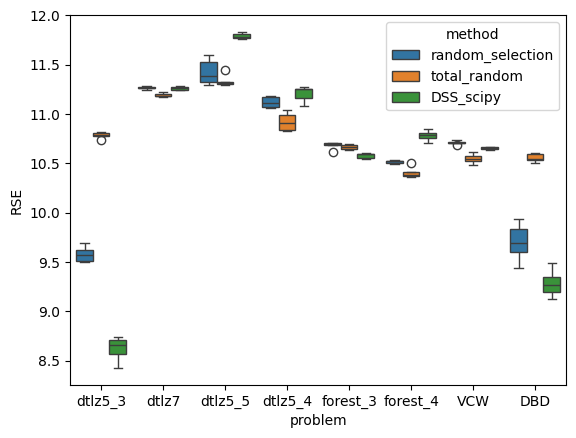

In [25]:
sns.boxplot(data=RSE_results, x="problem", y="RSE", hue="method")

In [30]:
RSE_results.groupby(["problem"], group_keys=True)["RSE"].apply(lambda x: x - x.min()).reset_index()

,problem,level_1,RSE
0,DBD,0,0.812278
1,DBD,0,0.702254
2,DBD,0,0.563676
3,DBD,0,0.309826
4,DBD,0,0.474329
...,...,...,...
115,forest_4,0,0.492310
116,forest_4,0,0.351344
117,forest_4,0,0.397440
118,forest_4,0,0.430423


<Axes: xlabel='iteration', ylabel='1-HV'>

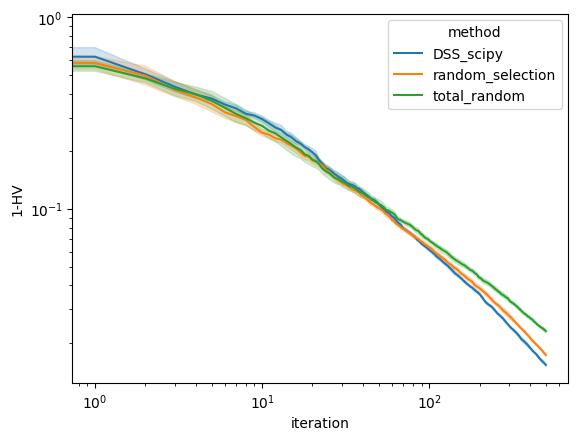

In [30]:
f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
f_pd["1-HV"] = 1 - f_pd["HV"]
sns.lineplot(data=f_pd, x="iteration", y="1-HV", hue="method")

# f.savefig(f"hv_{problem}.png")

In [5]:
rolling = pd.DataFrame(columns=["method", "runID", "iteration", "success"])

In [6]:
ids = f_pd["runID"].unique()
methods = f_pd["method"].unique()

for method in methods:
    for runID in ids:
        r = f_pd[(f_pd["method"] == method) & (f_pd["runID"] == runID)]
        rolling = pd.concat(
            [
                rolling,
                pd.DataFrame(
                    {
                        "method": [method] * len(r),
                        "runID": [runID] * len(r),
                        "iteration": r["iteration"],
                        "success": r["success"].cumsum(),
                    }
                ),
            ]
        )
rolling = rolling.dropna()

<Axes: xlabel='iteration', ylabel='success'>

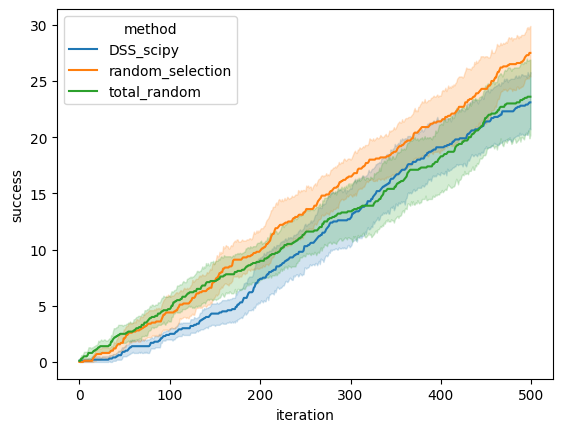

In [7]:
f, ax = plt.subplots()
sns.lineplot(data=rolling, x="iteration", y="Cumulative success", hue="method")
# f.savefig(f"success_{problem}.png")

<Axes: xlabel='iteration', ylabel='Bad Reference Points Found'>

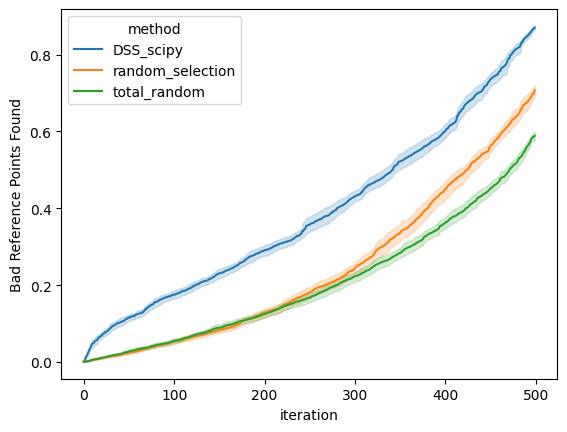

In [34]:
f, ax = plt.subplots()
sns.lineplot(data=f_pd, x="iteration", y="Bad Reference Points Found", hue="method")
# f.savefig(f"bad_ref_found_{problem}.png")